In [1]:
!pip install d2l==0.14.4


In [2]:
from d2l import torch as d2l
import torch
from torch import nn
import torch.nn.functional as F



In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [4]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [5]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [6]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # Here '@' stands for matrix multiplication
    return (H@W2 + b2)

In [7]:
loss = nn.CrossEntropyLoss()

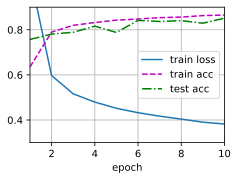

In [8]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

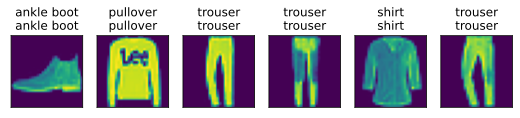

In [9]:
d2l.predict_ch3(net, test_iter)

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [12]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_iter:
        
        optimizer.zero_grad()
        
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in test_iter:
                out = model(images)
                test_loss += criterion(out, labels)
                
                # 로그 확률에 지수 적용 Xentropy 대신 exp 취한다면 NLL과 섞어 쓸 수 있음.
                ps = torch.exp(out) # 256 x 10                          
                scores, indices = ps.topk(1, dim=1) # 256 x 1

                # labels를 indices와 똑같은 형태로 만든다음에, 얼마나 같은게 있는지 확인한다.
                equals = indices == labels.view(*indices.shape)
                # equals를 float으로 바꾸고 평균 정확도를 구한다.
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(train_iter))
        test_losses.append(test_loss/len(test_iter))

        print("Epoch: {}/{} ".format(e+1, epochs),
              "Training Loss: {:.3f} ".format(running_loss/len(train_iter)),
              "Test Loss: {:.3f} ".format(test_loss/len(test_iter)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_iter)))

Epoch: 1/30  Training Loss: 0.657  Test Loss: 0.509  Test Accuracy: 0.823
Epoch: 2/30  Training Loss: 0.436  Test Loss: 0.438  Test Accuracy: 0.843
Epoch: 3/30  Training Loss: 0.394  Test Loss: 0.424  Test Accuracy: 0.851
Epoch: 4/30  Training Loss: 0.374  Test Loss: 0.394  Test Accuracy: 0.856
Epoch: 5/30  Training Loss: 0.357  Test Loss: 0.407  Test Accuracy: 0.858
Epoch: 6/30  Training Loss: 0.348  Test Loss: 0.396  Test Accuracy: 0.858
Epoch: 7/30  Training Loss: 0.336  Test Loss: 0.391  Test Accuracy: 0.861
Epoch: 8/30  Training Loss: 0.334  Test Loss: 0.412  Test Accuracy: 0.863
Epoch: 9/30  Training Loss: 0.324  Test Loss: 0.381  Test Accuracy: 0.869
Epoch: 10/30  Training Loss: 0.317  Test Loss: 0.400  Test Accuracy: 0.864
Epoch: 11/30  Training Loss: 0.312  Test Loss: 0.390  Test Accuracy: 0.867
Epoch: 12/30  Training Loss: 0.305  Test Loss: 0.366  Test Accuracy: 0.868
Epoch: 13/30  Training Loss: 0.302  Test Loss: 0.396  Test Accuracy: 0.864
Epoch: 14/30  Training Loss: 0.298

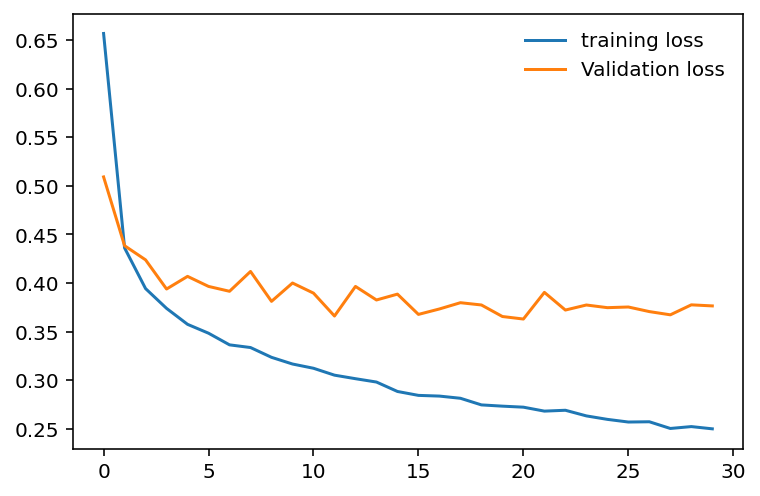

In [14]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)